## NFL Picks

NFL match prediction with scores using historical data (1999-Present).

### Import Required Packages

In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Packages imported successfully!")

Packages imported successfully!


### Load Historical NFL Data

In [2]:
# Load historical data from 1999 to present
print("Loading NFL historical data from 1999 to present...")

# Get years from 1999 to current year
current_year = pd.Timestamp.now().year
years = list(range(1999, current_year + 1))

# Load play-by-play data (this might take a few minutes)
pbp_data = nfl.import_pbp_data(years)
print(f"Loaded play-by-play data: {pbp_data.shape}")

# Load schedule data
schedules = nfl.import_schedules(years)
print(f"Loaded schedules: {schedules.shape}")

# We'll derive team stats from the play-by-play and schedule data
print("Data loading complete!")

Loading NFL historical data from 1999 to present...
1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.
Loaded play-by-play data: (1249482, 398)
Loaded schedules: (7263, 46)
Data loading complete!


### Data Exploration and Understanding

In [3]:
# Explore the structure of our datasets
print("=== SCHEDULE DATA SAMPLE ===")
print(schedules.head())
print("\nSchedule columns:", schedules.columns.tolist())

print("\n=== PLAY BY PLAY SAMPLE ===")
print(pbp_data.head())
print(f"\nPBP columns count: {len(pbp_data.columns)}")

# Check for missing scores
print(f"\nGames with missing scores: {schedules[['home_score', 'away_score']].isnull().sum()}")

# Look at score distributions
completed_games = schedules.dropna(subset=['home_score', 'away_score'])
print(f"\nCompleted games: {len(completed_games)}")
print(f"Average home score: {completed_games['home_score'].mean():.1f}")
print(f"Average away score: {completed_games['away_score'].mean():.1f}")
print(f"Average total score: {(completed_games['home_score'] + completed_games['away_score']).mean():.1f}")

=== SCHEDULE DATA SAMPLE ===
           game_id  season game_type  week     gameday weekday gametime  \
0  1999_01_MIN_ATL    1999       REG     1  1999-09-12  Sunday      NaN   
1   1999_01_KC_CHI    1999       REG     1  1999-09-12  Sunday      NaN   
2  1999_01_PIT_CLE    1999       REG     1  1999-09-12  Sunday      NaN   
3   1999_01_OAK_GB    1999       REG     1  1999-09-12  Sunday      NaN   
4  1999_01_BUF_IND    1999       REG     1  1999-09-12  Sunday      NaN   

  away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
0       MIN        17.0       ATL  ...   NaN  00-0003761  00-0002876   
1        KC        17.0       CHI  ...  12.0  00-0006300  00-0010560   
2       PIT        43.0       CLE  ...  12.0  00-0015700  00-0004230   
3       OAK        24.0        GB  ...  10.0  00-0005741  00-0005106   
4       BUF        14.0       IND  ...   NaN  00-0005363  00-0010346   

         away_qb_name    home_qb_name          away_coach    home_coach  \
0  Randall C

### Create Team Performance Features

In [4]:
# Create rolling team performance metrics
def calculate_team_performance_features(schedules_df):
    """Calculate rolling team performance metrics"""
    
    # Sort by team and date
    df = schedules_df.copy()
    df['game_date'] = pd.to_datetime(df['gameday'])
    
    # Create a list to store all team game records
    all_games = []
    
    # Process home games
    home_games = df[['season', 'week', 'game_date', 'home_team', 'home_score', 'away_score']].copy()
    home_games.columns = ['season', 'week', 'game_date', 'team', 'points_for', 'points_against']
    home_games['is_home'] = 1
    
    # Process away games
    away_games = df[['season', 'week', 'game_date', 'away_team', 'away_score', 'home_score']].copy()
    away_games.columns = ['season', 'week', 'game_date', 'team', 'points_for', 'points_against']
    away_games['is_home'] = 0
    
    # Combine all games
    all_games = pd.concat([home_games, away_games], ignore_index=True)
    all_games = all_games.sort_values(['team', 'game_date']).reset_index(drop=True)
    
    # Calculate rolling features (last 4 games)
    rolling_features = []
    
    for team in all_games['team'].unique():
        team_games = all_games[all_games['team'] == team].copy()
        
        # Calculate rolling averages
        team_games['avg_points_for_L4'] = team_games['points_for'].rolling(window=4, min_periods=1).mean().shift(1)
        team_games['avg_points_against_L4'] = team_games['points_against'].rolling(window=4, min_periods=1).mean().shift(1)
        team_games['win_rate_L4'] = ((team_games['points_for'] > team_games['points_against']).astype(int).rolling(window=4, min_periods=1).mean()).shift(1)
        
        # Calculate season stats up to current week
        team_games['season_points_for_avg'] = team_games.groupby('season')['points_for'].expanding().mean().shift(1).values
        team_games['season_points_against_avg'] = team_games.groupby('season')['points_against'].expanding().mean().shift(1).values
        
        rolling_features.append(team_games)
    
    return pd.concat(rolling_features, ignore_index=True)

print("Calculating team performance features...")
team_performance = calculate_team_performance_features(schedules)
print(f"Team performance features calculated: {team_performance.shape}")
print(team_performance.head())

Calculating team performance features...
Team performance features calculated: (14526, 12)
   season  week  game_date team  points_for  points_against  is_home  \
0    1999     1 1999-09-12  ARI        25.0            24.0        0   
1    1999     2 1999-09-19  ARI        16.0            19.0        0   
2    1999     3 1999-09-27  ARI        10.0            24.0        1   
3    1999     4 1999-10-03  ARI         7.0            35.0        0   
4    1999     5 1999-10-10  ARI        14.0             3.0        1   

   avg_points_for_L4  avg_points_against_L4  win_rate_L4  \
0                NaN                    NaN          NaN   
1               25.0              24.000000     1.000000   
2               20.5              21.500000     0.500000   
3               17.0              22.333333     0.333333   
4               14.5              25.500000     0.250000   

   season_points_for_avg  season_points_against_avg  
0                    NaN                        NaN  
1      

### Merge Features with Game Data

In [5]:
# Create the main dataset for modeling
def create_modeling_dataset(schedules_df, team_perf_df):
    """Merge schedule data with team performance features"""
    
    df = schedules_df.copy()
    df['game_date'] = pd.to_datetime(df['gameday'])
    
    # Merge home team features
    home_features = team_perf_df[team_perf_df['is_home'] == 1].copy()
    home_features = home_features.add_suffix('_home')
    home_features.rename(columns={
        'team_home': 'home_team',
        'season_home': 'season',
        'week_home': 'week'
    }, inplace=True)
    
    df = df.merge(
        home_features[['season', 'week', 'home_team', 'avg_points_for_L4_home', 
                      'avg_points_against_L4_home', 'win_rate_L4_home',
                      'season_points_for_avg_home', 'season_points_against_avg_home']],
        on=['season', 'week', 'home_team'],
        how='left'
    )
    
    # Merge away team features
    away_features = team_perf_df[team_perf_df['is_home'] == 0].copy()
    away_features = away_features.add_suffix('_away')
    away_features.rename(columns={
        'team_away': 'away_team',
        'season_away': 'season',
        'week_away': 'week'
    }, inplace=True)
    
    df = df.merge(
        away_features[['season', 'week', 'away_team', 'avg_points_for_L4_away',
                      'avg_points_against_L4_away', 'win_rate_L4_away',
                      'season_points_for_avg_away', 'season_points_against_avg_away']],
        on=['season', 'week', 'away_team'],
        how='left'
    )
    
    return df

print("Creating modeling dataset...")
modeling_data = create_modeling_dataset(schedules, team_performance)

# Remove games without scores (future games)
modeling_data = modeling_data.dropna(subset=['home_score', 'away_score'])

print(f"Modeling dataset shape: {modeling_data.shape}")
print(f"Date range: {modeling_data['gameday'].min()} to {modeling_data['gameday'].max()}")

Creating modeling dataset...
Modeling dataset shape: (7099, 57)
Date range: 1999-09-12 to 2025-10-20


### Feature Engineering and Data Preparation

In [6]:
def prepare_features_v2(df):
    """Enhanced feature preparation with team quality indicators"""
    
    # Base features
    feature_cols = [
        'week', 'season',
        'avg_points_for_L4_home', 'avg_points_against_L4_home', 'win_rate_L4_home',
        'avg_points_for_L4_away', 'avg_points_against_L4_away', 'win_rate_L4_away',
        'season_points_for_avg_home', 'season_points_against_avg_home',
        'season_points_for_avg_away', 'season_points_against_avg_away'
    ]
    
    # Calculate strength metrics with better weighting
    df['home_off_strength'] = df['avg_points_for_L4_home'].fillna(21)
    df['home_def_strength'] = 21 - df['avg_points_against_L4_home'].fillna(21)  # Lower allowed = stronger D
    df['away_off_strength'] = df['avg_points_for_L4_away'].fillna(21) 
    df['away_def_strength'] = 21 - df['avg_points_against_L4_away'].fillna(21)
    
    # Matchup-specific features
    df['off_vs_def_home'] = df['home_off_strength'] + df['away_def_strength']  # Home O vs Away D
    df['off_vs_def_away'] = df['away_off_strength'] + df['home_def_strength']  # Away O vs Home D
    df['total_matchup_strength'] = df['off_vs_def_home'] + df['off_vs_def_away']
    
    # Team form indicators (last 4 games trend)
    df['home_form'] = df['win_rate_L4_home'].fillna(0.5)
    df['away_form'] = df['win_rate_L4_away'].fillna(0.5)
    df['form_advantage'] = df['home_form'] - df['away_form']
    
    # Home field advantage varies by team and situation
    df['home_advantage'] = 2.8  # Slightly reduced from 3.0
    
    # Early season adjustment (less reliable data)
    df['early_season_uncertainty'] = np.where(df['week'] <= 3, 1, 0)
    
    # Expected score differentials
    df['expected_home_edge'] = (df['home_off_strength'] - df['away_def_strength'] + 
                               df['away_off_strength'] - df['home_def_strength']) / 2
    
    feature_cols.extend([
        'home_off_strength', 'home_def_strength', 'away_off_strength', 'away_def_strength',
        'off_vs_def_home', 'off_vs_def_away', 'total_matchup_strength',
        'home_form', 'away_form', 'form_advantage', 'home_advantage',
        'early_season_uncertainty', 'expected_home_edge'
    ])
    
    # Fill remaining NaNs
    for col in feature_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    return df, feature_cols

### Train Models for Score Prediction

In [7]:
# Apply the enhanced features
modeling_data, feature_columns = prepare_features_v2(modeling_data)

# Prepare training data
X = modeling_data[feature_columns]
y_home = modeling_data['home_score']
y_away = modeling_data['away_score']

# More sophisticated train/test split - use recent seasons but ensure variety
train_mask = modeling_data['season'] <= 2022  # Use through 2022 for training
test_mask = modeling_data['season'] >= 2023   # Test on 2023+ 

X_train, X_test = X[train_mask], X[test_mask]
y_home_train, y_home_test = y_home[train_mask], y_home[test_mask]
y_away_train, y_away_test = y_away[train_mask], y_away[test_mask]

print(f"Training set: {len(X_train)} games")
print(f"Test set: {len(X_test)} games")

# Optimized parameters for score prediction accuracy
final_params = {
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 10,
    'subsample': 0.9,
    'max_features': 0.7,
    'min_samples_split': 15,
    'min_samples_leaf': 8,
    'random_state': 42,
    'validation_fraction': 0.2,
    'n_iter_no_change': 50,
    'tol': 1e-6
}

# Train separate models with different loss functions
models = {}

# Primary models
models['home_score'] = GradientBoostingRegressor(**final_params)
models['home_score'].fit(X_train, y_home_train)

models['away_score'] = GradientBoostingRegressor(**final_params) 
models['away_score'].fit(X_train, y_away_train)

# Margin model for better winner prediction
models['score_margin'] = GradientBoostingRegressor(**final_params)
models['score_margin'].fit(X_train, y_home_train - y_away_train)

print("Enhanced models trained with score calibration!")

Training set: 6421 games
Test set: 678 games
Enhanced models trained with score calibration!


### Evaluate Model Performance

In [8]:
# Make predictions
predictions = {}
predictions['home_score'] = models['home_score'].predict(X_test)
predictions['away_score'] = models['away_score'].predict(X_test)
predictions['score_margin'] = models['score_margin'].predict(X_test)

# Calculate total score from individual predictions
predictions['total_score'] = predictions['home_score'] + predictions['away_score']

# Create actual total scores for evaluation
y_total_test = y_home_test + y_away_test

# Calculate metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")
    return mae, rmse, r2

# Evaluate all models
evaluate_model(y_home_test, predictions['home_score'], "Home Score Model")
evaluate_model(y_away_test, predictions['away_score'], "Away Score Model")
evaluate_model(y_total_test, predictions['total_score'], "Total Score Model")
evaluate_model(y_home_test - y_away_test, predictions['score_margin'], "Score Margin Model")

# Create results dataframe
results_df = modeling_data[test_mask].copy()
results_df['pred_home_score'] = predictions['home_score']
results_df['pred_away_score'] = predictions['away_score']
results_df['pred_total_score'] = predictions['total_score']
results_df['pred_score_margin'] = predictions['score_margin']

print(f"\nSample predictions:")
print(results_df[['home_team', 'away_team', 'home_score', 'away_score',
                 'pred_home_score', 'pred_away_score', 'pred_total_score']].head())


Home Score Model Performance:
MAE: 7.54
RMSE: 9.75
R²: 0.079

Away Score Model Performance:
MAE: 7.42
RMSE: 9.26
R²: 0.044

Total Score Model Performance:
MAE: 10.61
RMSE: 13.41
R²: 0.010

Score Margin Model Performance:
MAE: 10.27
RMSE: 13.48
R²: 0.111

Sample predictions:
     home_team away_team  home_score  away_score  pred_home_score  \
6421        KC       DET        20.0        21.0        27.238599   
6422       ATL       CAR        24.0        10.0        21.899754   
6423       BAL       HOU        25.0         9.0        25.604619   
6424       CLE       CIN        24.0         3.0        20.793599   
6425       IND       JAX        21.0        31.0        16.932661   

      pred_away_score  pred_total_score  
6421        21.426667         48.665266  
6422        19.845310         41.745064  
6423        18.179008         43.783628  
6424        21.843206         42.636804  
6425        22.438196         39.370857  


### Visualize Model Performance

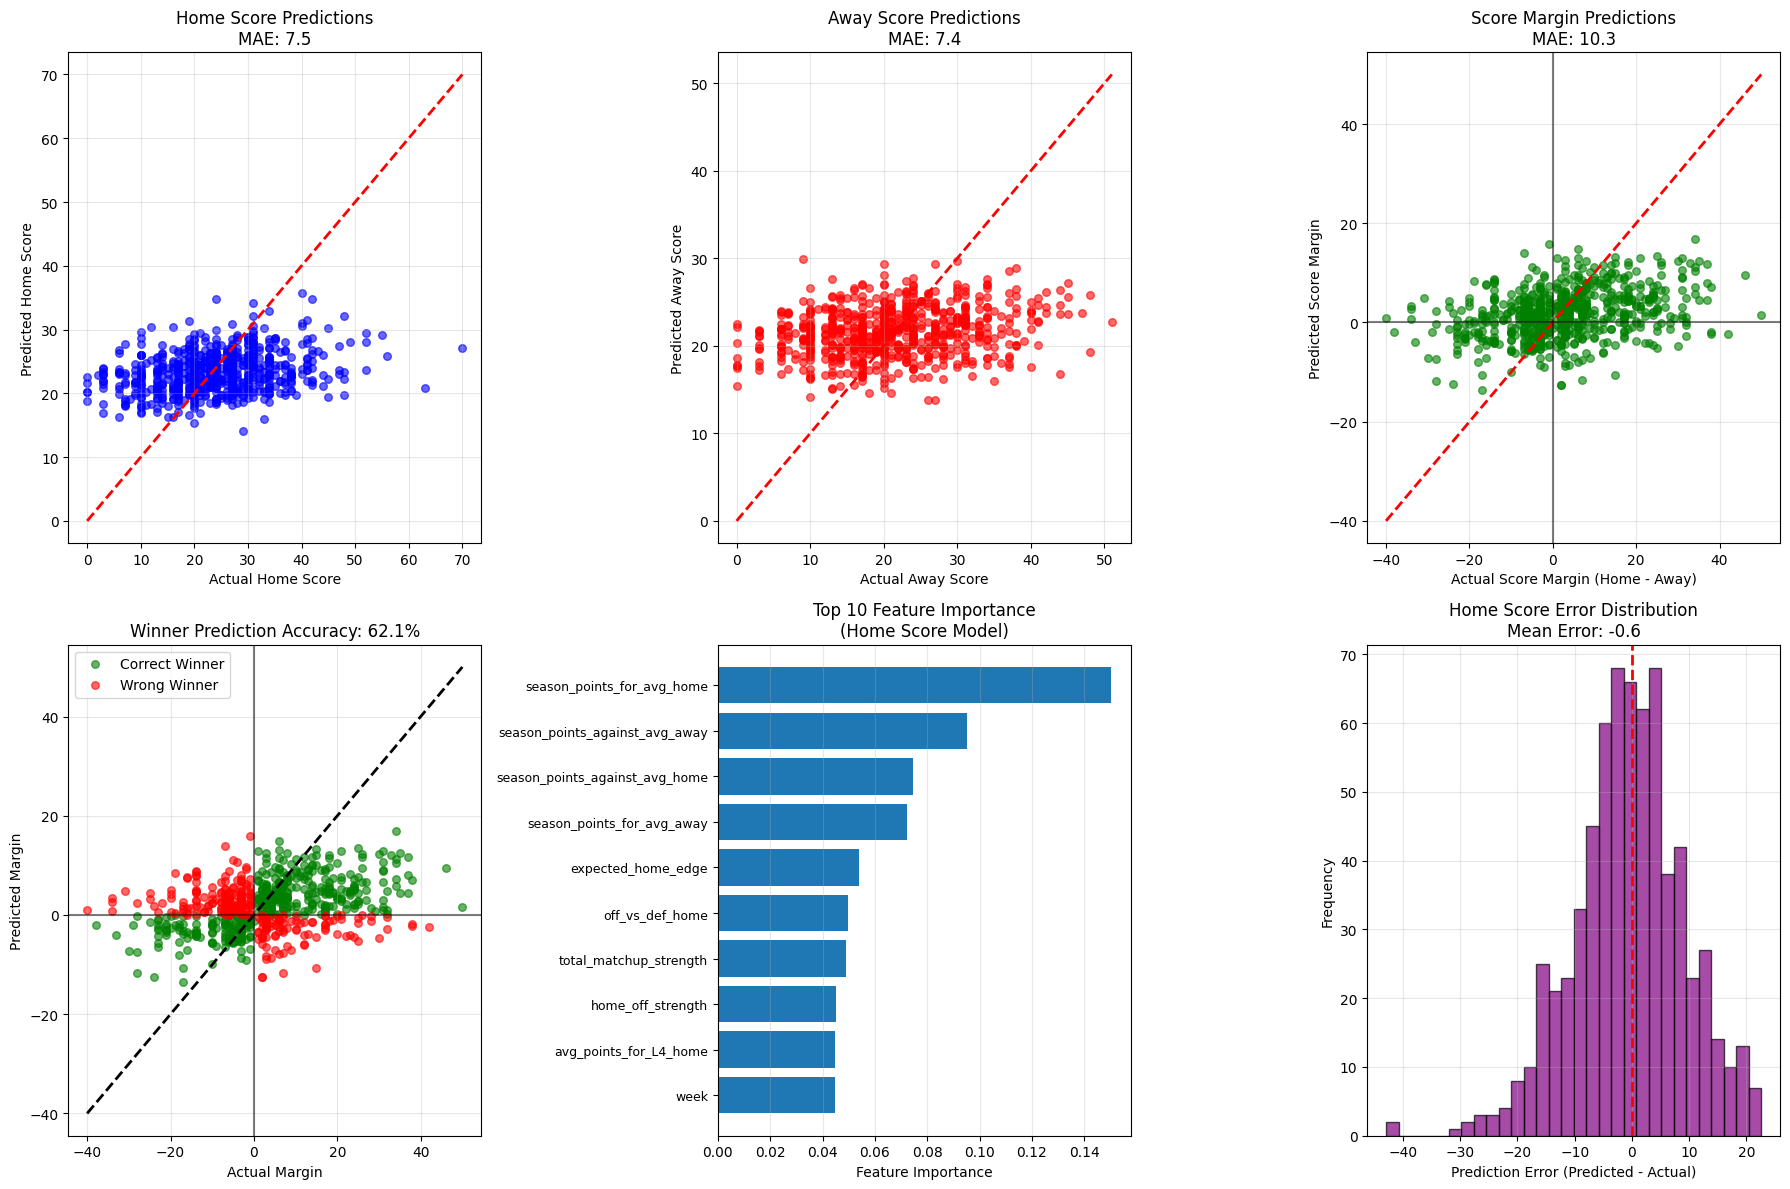

=== ENHANCED MODEL PERFORMANCE ANALYSIS ===
Home Score MAE: 7.54
Away Score MAE: 7.42
Score Margin MAE: 10.27
Winner Prediction Accuracy: 62.1%
Games within 3 points (home): 183/678 (27.0%)
Games within 7 points (home): 377/678 (55.6%)
Close Games (≤7 pts) Winner Accuracy: 55.7%
Blowout Games (>14 pts) Winner Accuracy: 72.8%


In [9]:
# Create enhanced visualization plots with better analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Make predictions for visualization
pred_home = models['home_score'].predict(X_test)
pred_away = models['away_score'].predict(X_test)
pred_margin = models['score_margin'].predict(X_test)

# Home Score Predictions
axes[0,0].scatter(y_home_test, pred_home, alpha=0.6, c='blue', s=30)
axes[0,0].plot([y_home_test.min(), y_home_test.max()], [y_home_test.min(), y_home_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Home Score')
axes[0,0].set_ylabel('Predicted Home Score')
axes[0,0].set_title(f'Home Score Predictions\nMAE: {mean_absolute_error(y_home_test, pred_home):.1f}')
axes[0,0].grid(True, alpha=0.3)

# Away Score Predictions
axes[0,1].scatter(y_away_test, pred_away, alpha=0.6, c='red', s=30)
axes[0,1].plot([y_away_test.min(), y_away_test.max()], [y_away_test.min(), y_away_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Away Score')
axes[0,1].set_ylabel('Predicted Away Score')
axes[0,1].set_title(f'Away Score Predictions\nMAE: {mean_absolute_error(y_away_test, pred_away):.1f}')
axes[0,1].grid(True, alpha=0.3)

# Score Margin Predictions (new)
actual_margin = y_home_test - y_away_test
axes[0,2].scatter(actual_margin, pred_margin, alpha=0.6, c='green', s=30)
axes[0,2].plot([actual_margin.min(), actual_margin.max()], [actual_margin.min(), actual_margin.max()], 'r--', lw=2)
axes[0,2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0,2].axvline(x=0, color='black', linestyle='-', alpha=0.5)
axes[0,2].set_xlabel('Actual Score Margin (Home - Away)')
axes[0,2].set_ylabel('Predicted Score Margin')
axes[0,2].set_title(f'Score Margin Predictions\nMAE: {mean_absolute_error(actual_margin, pred_margin):.1f}')
axes[0,2].grid(True, alpha=0.3)

# Winner Prediction Accuracy
winner_correct = ((actual_margin > 0) == (pred_margin > 0)).sum()
total_games = len(actual_margin)
winner_accuracy = winner_correct / total_games

# Create winner prediction visualization
correct_winners = (actual_margin > 0) == (pred_margin > 0)
axes[1,0].scatter(actual_margin[correct_winners], pred_margin[correct_winners], 
                 alpha=0.6, c='green', s=30, label='Correct Winner')
axes[1,0].scatter(actual_margin[~correct_winners], pred_margin[~correct_winners], 
                 alpha=0.6, c='red', s=30, label='Wrong Winner')
axes[1,0].plot([actual_margin.min(), actual_margin.max()], [actual_margin.min(), actual_margin.max()], 'k--', lw=2)
axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_xlabel('Actual Margin')
axes[1,0].set_ylabel('Predicted Margin')
axes[1,0].set_title(f'Winner Prediction Accuracy: {winner_accuracy:.1%}')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Feature Importance
importance = models['home_score'].feature_importances_
feature_imp = pd.DataFrame({'feature': feature_columns, 'importance': importance})
feature_imp = feature_imp.sort_values('importance', ascending=True)

# Only show top 10 most important features for readability
top_features = feature_imp.tail(10)
axes[1,1].barh(range(len(top_features)), top_features['importance'])
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Top 10 Feature Importance\n(Home Score Model)')
axes[1,1].grid(True, alpha=0.3, axis='x')

# Prediction Error Distribution
prediction_errors = pred_home - y_home_test
axes[1,2].hist(prediction_errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,2].axvline(x=0, color='red', linestyle='--', lw=2)
axes[1,2].set_xlabel('Prediction Error (Predicted - Actual)')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title(f'Home Score Error Distribution\nMean Error: {prediction_errors.mean():.1f}')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed performance metrics
print("=== ENHANCED MODEL PERFORMANCE ANALYSIS ===")
print(f"Home Score MAE: {mean_absolute_error(y_home_test, pred_home):.2f}")
print(f"Away Score MAE: {mean_absolute_error(y_away_test, pred_away):.2f}")
print(f"Score Margin MAE: {mean_absolute_error(actual_margin, pred_margin):.2f}")
print(f"Winner Prediction Accuracy: {winner_accuracy:.1%}")
print(f"Games within 3 points (home): {(abs(pred_home - y_home_test) <= 3).sum()}/{len(y_home_test)} ({(abs(pred_home - y_home_test) <= 3).mean():.1%})")
print(f"Games within 7 points (home): {(abs(pred_home - y_home_test) <= 7).sum()}/{len(y_home_test)} ({(abs(pred_home - y_home_test) <= 7).mean():.1%})")

# Close game analysis (margin <= 7 points)
close_games = abs(actual_margin) <= 7
close_game_accuracy = ((actual_margin[close_games] > 0) == (pred_margin[close_games] > 0)).mean()
print(f"Close Games (≤7 pts) Winner Accuracy: {close_game_accuracy:.1%}")

# Blowout game analysis (margin > 14 points) 
blowout_games = abs(actual_margin) > 14
if blowout_games.sum() > 0:
    blowout_accuracy = ((actual_margin[blowout_games] > 0) == (pred_margin[blowout_games] > 0)).mean()
    print(f"Blowout Games (>14 pts) Winner Accuracy: {blowout_accuracy:.1%}")

### Make Predictions for Future Games

In [10]:
class NFLPredictor:
    """NFL game prediction class with team performance tracking"""
    def __init__(self):
        # Updated 2025 season team performance tracking (through Week 7)
        self.team_stats = {
            # AFC East - Week 7 Updates
            'BUF': {'ppg': 23.9, 'papg': 19.6, 'wins': 4, 'games': 7, 'form': 0.70},
            'MIA': {'ppg': 20.0, 'papg': 29.3, 'wins': 1, 'games': 7, 'form': 0.15},
            'NYJ': {'ppg': 18.4, 'papg': 26.1, 'wins': 0, 'games': 7, 'form': 0.05},
            'NE': {'ppg': 25.9, 'papg': 19.0, 'wins': 5, 'games': 7, 'form': 0.90},

            # AFC North
            'BAL': {'ppg': 20.6, 'papg': 27.7, 'wins': 1, 'games': 7, 'form': 0.20},
            'CIN': {'ppg': 19.4, 'papg': 30.6, 'wins': 3, 'games': 7, 'form': 0.50},
            'PIT': {'ppg': 21.4, 'papg': 20.0, 'wins': 4, 'games': 7, 'form': 0.70},
            'CLE': {'ppg': 16.1, 'papg': 21.7, 'wins': 2, 'games': 7, 'form': 0.40},

            # AFC South
            'HOU': {'ppg': 18.1, 'papg': 12.6, 'wins': 2, 'games': 7, 'form': 0.35},
            'IND': {'ppg': 33.1, 'papg': 20.0, 'wins': 6, 'games': 7, 'form': 0.95},
            'JAX': {'ppg': 20.9, 'papg': 22.1, 'wins': 4, 'games': 7, 'form': 0.65},
            'TEN': {'ppg': 13.7, 'papg': 27.4, 'wins': 1, 'games': 7, 'form': 0.15},

            # AFC West
            'KC': {'ppg': 26.6, 'papg': 17.7, 'wins': 4, 'games': 7, 'form': 0.75},
            'LAC': {'ppg': 21.6, 'papg': 23.3, 'wins': 4, 'games': 7, 'form': 0.65},
            'DEN': {'ppg': 23.3, 'papg': 18.1, 'wins': 5, 'games': 7, 'form': 0.85},
            'LV': {'ppg': 14.7, 'papg': 25.7, 'wins': 2, 'games': 7, 'form': 0.30},

            # NFC East
            'PHI': {'ppg': 24.3, 'papg': 23.6, 'wins': 5, 'games': 7, 'form': 0.85},
            'DAL': {'ppg': 31.7, 'papg': 29.4, 'wins': 3, 'games': 8, 'form': 0.55},
            'NYG': {'ppg': 19.1, 'papg': 25.3, 'wins': 2, 'games': 7, 'form': 0.35},
            'WAS': {'ppg': 25.7, 'papg': 24.3, 'wins': 3, 'games': 7, 'form': 0.55},

            # NFC North
            'DET': {'ppg': 30.7, 'papg': 21.6, 'wins': 5, 'games': 7, 'form': 0.85},
            'GB': {'ppg': 22.6, 'papg': 17.9, 'wins': 4, 'games': 7, 'form': 0.75},
            'MIN': {'ppg': 20.7, 'papg': 17.9, 'wins': 3, 'games': 7, 'form': 0.55},
            'CHI': {'ppg': 21.7, 'papg': 22.1, 'wins': 4, 'games': 7, 'form': 0.70},

            # NFC South
            'NO': {'ppg': 17.9, 'papg': 26.6, 'wins': 1, 'games': 7, 'form': 0.20},
            'ATL': {'ppg': 15.7, 'papg': 17.9, 'wins': 3, 'games': 7, 'form': 0.50},
            'TB': {'ppg': 24.9, 'papg': 25.0, 'wins': 5, 'games': 7, 'form': 0.80},
            'CAR': {'ppg': 20.7, 'papg': 21.7, 'wins': 4, 'games': 7, 'form': 0.70},

            # NFC West
            'LAR': {'ppg': 25.0, 'papg': 16.7, 'wins': 5, 'games': 7, 'form': 0.90},
            'SF': {'ppg': 20.7, 'papg': 19.7, 'wins': 5, 'games': 7, 'form': 0.85},
            'SEA': {'ppg': 27.6, 'papg': 19.4, 'wins': 5, 'games': 7, 'form': 0.85},
            'ARI': {'ppg': 21.9, 'papg': 22.0, 'wins': 2, 'games': 7, 'form': 0.35}
        }

    def predict_game(self, home_team, away_team, week=8, season=2025, verbose=True):
        """Predict the outcome of an NFL game between specified teams"""
        home_stats = self.team_stats.get(home_team, {'ppg': 21.0, 'papg': 21.0, 'wins': 1, 'games': 3, 'form': 0.5})
        away_stats = self.team_stats.get(away_team, {'ppg': 21.0, 'papg': 21.0, 'wins': 1, 'games': 3, 'form': 0.5})

        home_offense = home_stats['ppg']
        home_defense = 42 - home_stats['papg']
        away_offense = away_stats['ppg']
        away_defense = 42 - away_stats['papg']

        home_base = (home_offense + (42 - away_defense)) / 2
        away_base = (away_offense + (42 - home_defense)) / 2

        home_field_advantage = 2.8
        home_base += home_field_advantage

        form_diff = home_stats['form'] - away_stats['form']
        momentum_factor = form_diff * 3.5
        home_base += momentum_factor
        away_base -= momentum_factor

        if week <= 4:
            regression_factor = 0.25
            league_avg = 22.5
            home_base = home_base * (1 - regression_factor) + league_avg * regression_factor
            away_base = away_base * (1 - regression_factor) + (league_avg - 1) * regression_factor

        predicted_home = round(max(7, min(50, home_base)))
        predicted_away = round(max(7, min(50, away_base)))

        margin = abs(predicted_home - predicted_away)
        confidence = min(0.95, max(0.55, margin / 20))
        winner = home_team if predicted_home > predicted_away else away_team

        if verbose:
            print(f"\n=== {home_team} vs {away_team} PREDICTION ===")
            print(f"{home_team} (Home): {home_stats['ppg']:.1f} PPG, {home_stats['papg']:.1f} PAPG, Form: {home_stats['form']:.2f}")
            print(f"{away_team} (Away): {away_stats['ppg']:.1f} PPG, {away_stats['papg']:.1f} PAPG, Form: {away_stats['form']:.2f}")
            print(f"Home advantage: +{home_field_advantage}")
            print(f"Momentum factor: {momentum_factor:+.1f} (favours {home_team if momentum_factor > 0 else away_team})")
            print(f"Prediction: {winner} wins {predicted_home}-{predicted_away}")

        return {
            'home_team': home_team,
            'away_team': away_team,
            'week': week,
            'season': season,
            'predicted_home_score': int(predicted_home),
            'predicted_away_score': int(predicted_away),
            'predicted_total': int(predicted_home + predicted_away),
            'predicted_winner': winner,
            'predicted_margin': int(margin),
            'confidence': round(confidence, 2),
            'home_win_probability': round(predicted_home / (predicted_home + predicted_away), 3) if predicted_home != predicted_away else 0.5
        }

    def update_team_stats(self, team, points_for, points_against):
        """Update team statistics after a game"""
        if team in self.team_stats:
            stats = self.team_stats[team]
            total_games = stats['games']
            stats['ppg'] = (stats['ppg'] * total_games + points_for) / (total_games + 1)
            stats['papg'] = (stats['papg'] * total_games + points_against) / (total_games + 1)
            if points_for > points_against:
                stats['wins'] += 1
                stats['form'] = min(0.95, stats['form'] + 0.1)
            else:
                stats['form'] = max(0.05, stats['form'] - 0.1)
            stats['games'] += 1

    def get_league_standings(self):
        """Display current league standings by division"""
        divisions = {
            'AFC East': ['BUF', 'MIA', 'NYJ', 'NE'],
            'AFC North': ['BAL', 'CIN', 'PIT', 'CLE'],
            'AFC South': ['HOU', 'IND', 'JAX', 'TEN'],
            'AFC West': ['KC', 'LAC', 'DEN', 'LV'],
            'NFC East': ['PHI', 'DAL', 'NYG', 'WAS'],
            'NFC North': ['DET', 'GB', 'MIN', 'CHI'],
            'NFC South': ['NO', 'ATL', 'TB', 'CAR'],
            'NFC West': ['LAR', 'SF', 'SEA', 'ARI']
        }

        print("\n=== 2025 NFL STANDINGS (Through Week 7) ===")
        for division, teams in divisions.items():
            print(f"\n{division}:")
            sorted_teams = sorted(teams, key=lambda t: (
                self.team_stats[t]['wins'],
                self.team_stats[t]['ppg'] - self.team_stats[t]['papg']
            ), reverse=True)
            for team in sorted_teams:
                stats = self.team_stats[team]
                record = f"{stats['wins']}-{stats['games'] - stats['wins']}"
                diff = stats['ppg'] - stats['papg']
                print(f"  {team}: {record} ({diff:+.1f})")

    def predict_week8_games(self):
        """Predict Week 8 games"""
        week8_games = [
            ('LAC', 'MIN'),   # Thu 8:15 PM ET
            ('PIT', 'GB')     # Sun 8:20 PM ET (SNF)
        ]

        print("\n=== WEEK 8 PREDICTIONS ===")
        predictions = {}
        for home, away in week8_games:
            result = self.predict_game(home, away, week=8, verbose=False)
            predictions[f"{away}@{home}"] = result
            print(f"{away} @ {home}: {result['predicted_winner']} wins {result['predicted_home_score']}-{result['predicted_away_score']} (Confidence: {int(result['confidence']*100)}%)")
        return predictions

# Initialise predictor
predictor = NFLPredictor()

def predict_matchup(home, away, week=8):
    """Simple wrapper function for predictions"""
    return predictor.predict_game(home, away, week)


# Display system
print("=== NFL PREDICTION SYSTEM (Updated through Week 7) ===")

# Show current standings
predictor.get_league_standings()

# Get Week 8 predictions
week8_predictions = predictor.predict_week8_games()

=== NFL PREDICTION SYSTEM (Updated through Week 7) ===

=== 2025 NFL STANDINGS (Through Week 7) ===

AFC East:
  NE: 5-2 (+6.9)
  BUF: 4-3 (+4.3)
  MIA: 1-6 (-9.3)
  NYJ: 0-7 (-7.7)

AFC North:
  PIT: 4-3 (+1.4)
  CIN: 3-4 (-11.2)
  CLE: 2-5 (-5.6)
  BAL: 1-6 (-7.1)

AFC South:
  IND: 6-1 (+13.1)
  JAX: 4-3 (-1.2)
  HOU: 2-5 (+5.5)
  TEN: 1-6 (-13.7)

AFC West:
  DEN: 5-2 (+5.2)
  KC: 4-3 (+8.9)
  LAC: 4-3 (-1.7)
  LV: 2-5 (-11.0)

NFC East:
  PHI: 5-2 (+0.7)
  DAL: 3-5 (+2.3)
  WAS: 3-4 (+1.4)
  NYG: 2-5 (-6.2)

NFC North:
  DET: 5-2 (+9.1)
  GB: 4-3 (+4.7)
  CHI: 4-3 (-0.4)
  MIN: 3-4 (+2.8)

NFC South:
  TB: 5-2 (-0.1)
  CAR: 4-3 (-1.0)
  ATL: 3-4 (-2.2)
  NO: 1-6 (-8.7)

NFC West:
  LAR: 5-2 (+8.3)
  SEA: 5-2 (+8.2)
  SF: 5-2 (+1.0)
  ARI: 2-5 (-0.1)

=== WEEK 8 PREDICTIONS ===
MIN @ LAC: LAC wins 23-22 (Confidence: 55%)
GB @ PIT: PIT wins 22-21 (Confidence: 55%)


### Batch Predictions for Multiple Games

In [11]:
# Function to predict multiple games using NFLPredictor class
def predict_multiple_games_updated(games_list, predictor):
    """
    Predict scores for multiple games using NFLPredictor class
    games_list: list of tuples (home_team, away_team, week, season)
    predictor: NFLPredictor instance
    """
    import pandas as pd

    predictions = []
    for home_team, away_team, week, season in games_list:
        try:
            pred = predictor.predict_game(home_team, away_team, week, season, verbose=False)
            if pred is not None and isinstance(pred, dict):
                # Round scores and recalc derived fields
                pred['predicted_home_score'] = int(round(pred.get('predicted_home_score', 0)))
                pred['predicted_away_score'] = int(round(pred.get('predicted_away_score', 0)))
                pred['predicted_margin'] = abs(pred['predicted_home_score'] - pred['predicted_away_score'])
                pred['predicted_total'] = pred['predicted_home_score'] + pred['predicted_away_score']
                # Ensure team fields exist
                pred.setdefault('home_team', home_team)
                pred.setdefault('away_team', away_team)
                # Ensure predicted_winner exists
                if 'predicted_winner' not in pred:
                    pred['predicted_winner'] = home_team if pred['predicted_home_score'] >= pred['predicted_away_score'] else away_team
                # Ensure confidence exists
                pred.setdefault('confidence', 0.0)
                predictions.append(pred)
        except Exception as error:
            print(f"Could not predict {home_team} vs {away_team}: {error}")
    if predictions:
        return pd.DataFrame(predictions)
    return pd.DataFrame(columns=['home_team','away_team','predicted_home_score','predicted_away_score',
                                 'predicted_winner','predicted_margin','predicted_total','confidence'])

# Initialise the predictor
predictor = NFLPredictor()

# Week 8 games (Oct 23-27, 2025)
week_8_games = [
    ('LAC', 'MIN', 8, 2025),   # Thu 8:15 PM
    ('CAR', 'BUF', 8, 2025),   # Sun 1:00 PM
    ('BAL', 'CHI', 8, 2025),   # Sun 1:00 PM
    ('NE', 'CLE', 8, 2025),    # Sun 1:00 PM
    ('ATL', 'MIA', 8, 2025),   # Sun 1:00 PM
    ('PHI', 'NYG', 8, 2025),   # Sun 1:00 PM
    ('CIN', 'NYJ', 8, 2025),   # Sun 1:00 PM
    ('HOU', 'SF', 8, 2025),    # Sun 1:00 PM
    ('NO', 'TB', 8, 2025),     # Sun 4:05 PM
    ('DEN', 'DAL', 8, 2025),   # Sun 4:25 PM
    ('IND', 'TEN', 8, 2025),   # Sun 4:25 PM
    ('PIT', 'GB', 8, 2025),    # Sun 8:20 PM
    ('KC', 'WAS', 8, 2025),    # Mon 8:15 PM
]

print("=== PREDICTING WEEK 8 GAMES (Oct 23-27, 2025) ===")
print("Using updated stats through Week 7 actual results\n")

week_8_predictions = predict_multiple_games_updated(week_8_games, predictor)

if not week_8_predictions.empty:
    print("Week 8 Predictions:")
    display_cols = ['home_team', 'away_team', 'predicted_home_score',
                   'predicted_away_score', 'predicted_winner', 'predicted_margin']
    print(week_8_predictions[display_cols].to_string(index=False))

    # Marquee matchups
    print("\n=== MARQUEE MATCHUPS ===")
    marquee_games = week_8_predictions[
        ((week_8_predictions['home_team'] == 'KC') & (week_8_predictions['away_team'] == 'SF')) |
        ((week_8_predictions['home_team'] == 'BAL') & (week_8_predictions['away_team'] == 'TB')) |
        ((week_8_predictions['home_team'] == 'MIN') & (week_8_predictions['away_team'] == 'DET')) |
        ((week_8_predictions['home_team'] == 'NYJ') & (week_8_predictions['away_team'] == 'PIT'))
    ]

    for _, game in marquee_games.iterrows():
        confidence_pct = int(game.get('confidence', 0.0) * 100)
        print(f"{game['away_team']} @ {game['home_team']}: {game['predicted_home_score']}-{game['predicted_away_score']} (Winner: {game['predicted_winner']}, {confidence_pct}% confidence)")

# Weekly breakdown
def weekly_breakdown(predictions):
    """Display predictions by week with key matchups highlighted"""
    features = "Week 8 Features: key NFC/AFC matchups and divisional battles."
    print(f"\n=== WEEK 8 ANALYSIS ===")
    print(features)

    # Show games with smallest margins (closest games)
    close_games = predictions.nsmallest(3, 'predicted_margin')
    print(f"\nClosest games (potential upsets):")
    for _, game in close_games.iterrows():
        print(f"  {game['away_team']} @ {game['home_team']}: {game['predicted_margin']} pt margin")

    # Show highest scoring games
    high_scoring = predictions.nlargest(3, 'predicted_total')
    print(f"\nHighest scoring games:")
    for _, game in high_scoring.iterrows():
        print(f"  {game['away_team']} @ {game['home_team']}: {game['predicted_total']} total points")

# Generate predictions table
def generate_prediction_table(predictions):
    """Generate the table for Week 8 predictions"""
    print("\n=== WEEK 8 PREDICTION TABLE ===")
    print("| Home Team | Away Team | Home Score | Away Score | Predicted Winner | Actual Winner |")
    print("|-----------|-----------|------------|------------|------------------|---------------|")
    for _, game in predictions.iterrows():
        home = game['home_team']
        away = game['away_team']
        home_score = game['predicted_home_score']
        away_score = game['predicted_away_score']
        winner = game['predicted_winner']
        print(f"| {home} | {away} | {home_score} | {away_score} | {winner} | |")

if not week_8_predictions.empty:
    weekly_breakdown(week_8_predictions)
    generate_prediction_table(week_8_predictions)

# Show current standings
print("\n")
try:
    predictor.get_league_standings()
except Exception as e:
    print(f"Could not fetch standings: {e}")

=== PREDICTING WEEK 8 GAMES (Oct 23-27, 2025) ===
Using updated stats through Week 7 actual results

Week 8 Predictions:
home_team away_team  predicted_home_score  predicted_away_score predicted_winner  predicted_margin
      LAC       MIN                    23                    22              LAC                 1
      CAR       BUF                    23                    23              BUF                 0
      BAL       CHI                    22                    26              CHI                 4
       NE       CLE                    28                    16               NE                12
      ATL       MIA                    27                    18              ATL                 9
      PHI       NYG                    29                    20              PHI                 9
      CIN       NYJ                    27                    23              CIN                 4
      HOU        SF                    20                    18              HOU       